In [12]:
import numpy as np
import pandas as pd
import datetime
from dateutil.parser import parse
import requests, re, time
import pandas_datareader
import pickle
import math

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns 

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import linearmodels as ln
from pystout import pystout

import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from selenium import webdriver
import time

import geopy.distance

In [13]:
Apartments = pickle.load(open('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data 4.pkl','rb'))
Apartments['Year Sold'] = [i.year for i in Apartments['Date_sold']]
Apartments['Closest Metro dist'] = [i['Distance'] for i in Apartments['Closest Metro']]
Apartments['Cityring'] = [i['Cityring'] for i in Apartments['Closest Metro']]
Apartments['sq_m'] = (Apartments['Price']/1000)/Apartments['Price_sq_m_1000']
Apartments['log_price_sq_m_1000'] = np.log(Apartments['Price'])
Cityring = Apartments[(Apartments['Cityring'] == 1)]

In [14]:
# Cutting old years away:
Cityring = Cityring[(Cityring['Year Sold'] > 2016)]
Cityring.reset_index(inplace=True)
del Cityring['index']

In [15]:
# Setting time-variable:
Cityring['Years From Completion'] = Cityring['Year Sold'] - 2019

In [16]:
# Generating distance-intervals:
Cityring['Distance Interval'] = 'NaN'
for i in range(0,len(Cityring)):
    if Cityring['Closest Metro dist'][i] < 0.2:
        Cityring['Distance Interval'][i] = '200m'
    elif 0.2 < Cityring['Closest Metro dist'][i] < 0.4:
        Cityring['Distance Interval'][i] = '400m'
    elif 0.4 < Cityring['Closest Metro dist'][i] < 0.6:
        Cityring['Distance Interval'][i] = '600m'
    elif 0.6 < Cityring['Closest Metro dist'][i] < 1:
        Cityring['Distance Interval'][i] = '1km'
    elif Cityring['Closest Metro dist'][i] > 1:
        Cityring['Distance Interval'][i] = 'Further'

In [17]:
year_dummies = pd.get_dummies(Cityring['Year Sold'])
year_list = [str(i) for i in year_dummies.columns]
year_dummies.columns = year_list
area_dummies = pd.get_dummies(Cityring['Area'])
distance_dummies = pd.get_dummies(Cityring['Distance Interval'])
# Avoiding the dummy-trap by removing base categories:
del year_dummies['2019']
del area_dummies['NaN']
del distance_dummies['Further']

In [18]:
X = pd.DataFrame()
X['Rooms'] = Cityring['Rooms']
X['sq_m'] = Cityring['sq_m']
X = pd.merge(X,year_dummies,left_index=True,right_index=True)
X = pd.merge(X,area_dummies,left_index=True,right_index=True)
X = pd.merge(X,distance_dummies,left_index=True,right_index=True)

# Interactions:
for year in year_dummies.columns:
    for distance in distance_dummies.columns:
        X[f'{year}X{distance}'] = X[f'{year}'] * X[f'{distance}']

In [47]:
X = sm.add_constant(X)
model = sm.OLS(Cityring['log_price_sq_m_1000'],X)
results = model.fit(cov_type='HC1')
print(results.summary())

OLS Regression Results                            
Dep. Variable:     log_price_sq_m_1000   R-squared:                       0.504
Model:                             OLS   Adj. R-squared:                  0.503
Method:                  Least Squares   F-statistic:                     304.5
Date:                 Mon, 03 Aug 2020   Prob (F-statistic):               0.00
Time:                         11:15:04   Log-Likelihood:                -7011.1
No. Observations:                12738   AIC:                         1.408e+04
Df Residuals:                    12710   BIC:                         1.429e+04
Df Model:                           27                                         
Covariance Type:                   HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.9481      0.028    502.648      0.000      13.894     

In [48]:
pystout(models=[results],
        file='/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Tex files/Metro Regressions 2.tex',
        digits=3,
        endog_names=['Opening'],
        varlabels={'const':'Constant','displacement':'Disp','mpg':'MPG'},
        mgroups={'y = log(Price per sq. m, DKK)':[1,3]},
        modstat={'nobs':'Obs','rsquared_adj':'Adj. R\sym{2}','fvalue':'F-stat'}
        )

In [49]:
results_as_html = results.summary().tables[1].as_html()
df = pd.read_html(results_as_html, header=0, index_col=0)[0]
df = df[16:]
df

,coef,std err,z,P>|z|,[0.025,0.975]
2017X1km,0.0286,0.032,0.885,0.376,-0.035,0.092
2017X200m,-0.0906,0.047,-1.919,0.055,-0.183,0.002
2017X400m,-0.0354,0.031,-1.124,0.261,-0.097,0.026
2017X600m,-0.0167,0.030,-0.551,0.582,-0.076,0.043
2018X1km,0.0366,0.033,1.123,0.262,-0.027,0.101
2018X200m,0.0225,0.042,0.534,0.593,-0.060,0.105
2018X400m,-0.0206,0.031,-0.654,0.513,-0.082,0.041
2018X600m,-0.0386,0.031,-1.229,0.219,-0.100,0.023
2020X1km,0.1133,0.041,2.764,0.006,0.033,0.194
2020X200m,0.1295,0.047,2.734,0.006,0.037,0.222


In [50]:
ParamValues = pd.DataFrame()
ParamErrors = pd.DataFrame()

# WORKING WITH PARAMETER VALUES
ParamValues['200m'] = [df['coef'][i] for i in range(1,len(df)+1,4)]
ParamValues['400m'] = [df['coef'][i] for i in range(2,len(df)+2,4)]
ParamValues['600m'] = [df['coef'][i] for i in range(3,len(df)+3,4)]
ParamValues['1km'] = [df['coef'][i] for i in range(0,len(df),4)]

# Putting 0-row inside dfs:
begin = ParamValues[:-1]
middle = pd.DataFrame(data=[[0,0,0,0]],columns=ParamValues.columns)
end = ParamValues[-1:]
ParamValues = pd.concat([begin,middle,end],ignore_index=True)
ParamValues['Year'] = [int(i)-2019 for i in year_list]

# WORKING WITH STANDARD ERRORS FOR CONFIDENCE INTERVALS
ParamErrors['200m std err'] = [df['std err'][i] for i in range(1,len(df)+1,4)]
ParamErrors['400m std err'] = [df['std err'][i] for i in range(2,len(df)+2,4)]
ParamErrors['600m std err'] = [df['std err'][i] for i in range(3,len(df)+3,4)]
ParamErrors['1km std err'] = [df['std err'][i] for i in range(0,len(df),4)]

# Putting 0-row inside dfs:
begin = ParamErrors[:-1]
middle = pd.DataFrame(data=[[0,0,0,0]],columns=ParamErrors.columns)
end = ParamErrors[-1:]
ParamErrors = pd.concat([begin,middle,end],ignore_index=True)
ParamErrors['Year'] = year_list

In [51]:
# Showing relevant later years:
ParamValues_figure = ParamValues[-4:]
ParamErrors_figure = ParamErrors[-4:]
ParamErrors_figure

,200m std err,400m std err,600m std err,1km std err,Year
0,0.047,0.031,0.030,0.032,2017
1,0.042,0.031,0.031,0.033,2018
2,0.000,0.000,0.000,0.000,2019
3,0.047,0.040,0.040,0.041,2020


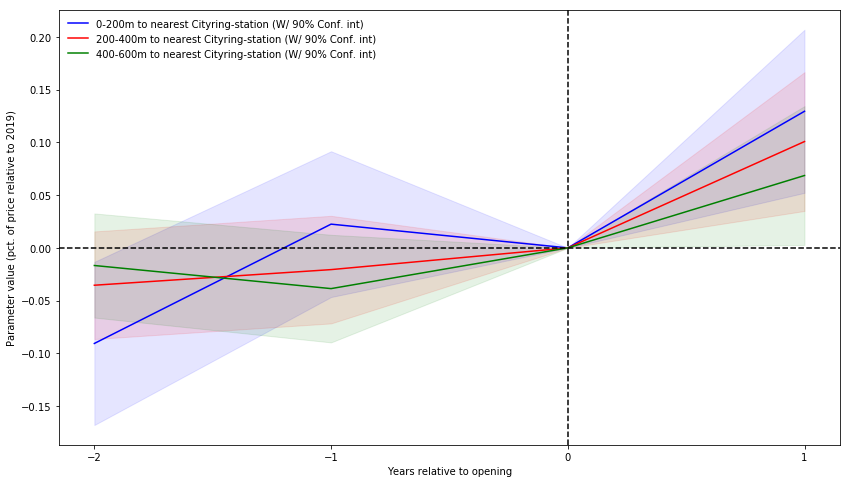

In [52]:
#Setting up the figure:
fig = plt.figure(figsize=(14,8), frameon=False)
title_font = {'size':'16', 'color':'black', 'weight':'bold',
              'verticalalignment':'bottom'}
#plt.title('Price change around opening of the Cityring',**title_font)
#plt.axis('off')


#Figure 1
plt.plot(ParamValues_figure['Year'], ParamValues_figure['200m'], c = 'blue', label = '0-200m to nearest Cityring-station (W/ 90% Conf. int)')
plt.plot(ParamValues_figure['Year'],ParamValues_figure['400m'], c = 'red', label = '200-400m to nearest Cityring-station (W/ 90% Conf. int)')
plt.plot(ParamValues_figure['Year'],ParamValues_figure['600m'], c = 'green' , label = '400-600m to nearest Cityring-station (W/ 90% Conf. int)')

plt.fill_between(ParamValues_figure['Year'], (ParamValues_figure['200m']-ParamErrors_figure['200m std err']*1.645), (ParamValues_figure['200m']+ParamErrors_figure['200m std err']*1.645), color='b', alpha=.1)
plt.fill_between(ParamValues_figure['Year'], (ParamValues_figure['400m']-ParamErrors_figure['400m std err']*1.645), (ParamValues_figure['400m']+ParamErrors_figure['400m std err']*1.645), color='red', alpha=.1)
plt.fill_between(ParamValues_figure['Year'], (ParamValues_figure['600m']-ParamErrors_figure['600m std err']*1.645), (ParamValues_figure['600m']+ParamErrors_figure['600m std err']*1.645), color='green', alpha=.1)



plt.axhline(0,c='black',linestyle='--')
plt.axvline(0,c='black',linestyle='--')

plt.xticks(np.arange(-2, 1.5, 1.0))

plt.ylabel('Parameter value (pct. of price relative to 2019)')
plt.xlabel('Years relative to opening')

legend1 = plt.legend(loc = 'upper left', frameon=False)
plt.savefig('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Other data/Price change around opening.pdf')
plt.show()

In [53]:
Bar_data = ParamValues[-1:]
Bar_data.reset_index(inplace=True)
del Bar_data['index']
del Bar_data['Year']

stderr = ParamErrors[-1:]
stderr.reset_index(inplace=True)
del stderr['index']
del stderr['Year']


No_obs = X.describe().iloc[1,-4:]
No_obs_sorted = [No_obs[1],No_obs[2],No_obs[3],No_obs[0]]
No_obs_sorted = [i*15 for i in No_obs_sorted]

In [54]:
x_vals = Bar_data.columns.to_list()
y_vals = Bar_data.iloc[0,:]
CI_len = [] # 90% Confidence interval
for i in stderr.iloc[0,:]:
    CI_len.append(i*1.645)

<Figure size 576x288 with 0 Axes>

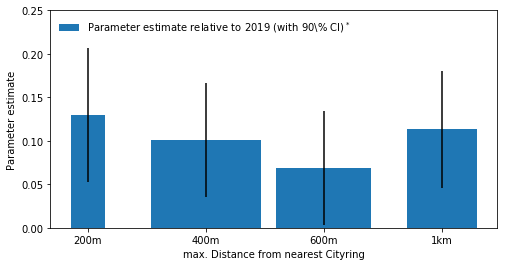

In [55]:
fig = plt.figure(figsize=(8,4), frameon=False)
title_font = {'size':'16', 'color':'black', 'weight':'bold',
              'verticalalignment':'bottom'}
#plt.title('Price change around opening of the Cityring',**title_font)
#plt.axis('off')

g = plt.figure(figsize=(8,4), frameon=False)
title_font = {'size':'16', 'color':'black', 'weight':'bold',
              'verticalalignment':'bottom'}
#plt.title('Price change around opening of the Cityring',**title_font)
#plt.axis('off')

plt.bar(x=x_vals,height=y_vals,yerr=CI_len,width=No_obs_sorted, label='Parameter estimate relative to 2019 (with 90\% CI)$^*$')

plt.ylabel('Parameter estimate')
plt.xlabel('max. Distance from nearest Cityring')

plt.ylim(0,0.25)

legend1 = plt.legend(loc = 'upper left', frameon=False)

plt.savefig('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Other data/Price distance.pdf')